### E-commerce

Sales data from the online store.
There are three data tables:
1. df_orders - Orders table 
2. df_customers - Table with unique user identifiers
3. df_item - Items included in orders

I will analyze completed purchases and answer the following questions:

1. How many users have made a purchase only once?

2. On average, how many orders per month are not delivered for various reasons? (Provide a breakdown by reasons)

3. For each item, determine which day of the week it is most frequently purchased.

4. How many purchases per week does each user make on average (per month)?

5. I will perform cohort analysis of users.

6. I will build RFM segmentation of users to qualitatively assess our audience.

In [1]:
import pandas as pd 
import numpy as np
from datetime import datetime
import calendar
import requests
from urllib.parse import urlencode
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta




In [2]:
# Base URL for accessing Yandex Disk
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
# File URLs on Yandex Disk
url_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
url_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
url_order_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

# Creating final URLs for downloading each file by combining the base URL and query parameters
# using the urlencode() function from the urllib.parse module
final_url_customers = base_url + urlencode(dict(public_key=url_customers))
final_url_orders = base_url + urlencode(dict(public_key=url_orders))
final_url_key_order_items = base_url + urlencode(dict(public_key=url_order_items))

# Making requests to the Yandex Disk API to download the files using the generated final URLs
# The requests.get() function returns a response in JSON format, from which the download URL ('href') is extracted
df_customers = pd.read_csv(requests.get(final_url_customers).json()['href'])
df_orders = pd.read_csv(requests.get(final_url_orders).json()['href'])
df_items = pd.read_csv(requests.get(final_url_key_order_items).json()['href'])


### EDA

Orders table df_orders
- order_id — unique order identifier (receipt number)
- customer_id — customer identifier per order
- order_status — order status
- order_purchase_timestamp — order creation time
- order_approved_at — order payment confirmation time
- order_delivered_carrier_date — time the order was handed over to the logistics service
- order_delivered_customer_date — order delivery time
- order_estimated_delivery_date — promised delivery date

In [3]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Users table df_customers
- customer_id — customer identifier per order
- customer_unique_id — unique customer identifier (similar to a passport number)
- customer_zip_code_prefix — customer's postal code
- customer_city — customer's delivery city
- customer_state — customer's delivery state

In [4]:
df_customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Items table df_items
- order_id — unique order identifier (receipt number)
- order_item_id — item identifier within an order
- product_id — product ID (similar to a barcode)
- seller_id — product manufacturer ID
- shipping_limit_date — latest delivery date for the seller to hand over the order to the logistics partner
- price — price per item
- freight_value — freight weight

In [5]:
df_items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [6]:
df_orders.describe(include='all')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
count,99441,99441,99441,99441,99281,97658,96476,99441
unique,99441,99441,8,98875,90733,81018,95664,459
top,20dbf24263d2b7197c8d23bee91cb263,d8b96ce90eca97230eacd6cde064599d,delivered,2018-03-31 15:08:21,2018-02-27 04:31:10,2018-05-09 15:48:00,2018-05-08 19:36:48,2017-12-20 00:00:00
freq,1,1,96478,3,9,47,3,522


In [7]:
df_items.describe(include='all')


,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
count,112650,112650.000000,112650,112650,112650,112650.000000,112650.000000
unique,98666,NaN,32951,3095,93318,NaN,NaN
top,8272b63d03f5f79c56e9e4120aec44ef,NaN,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2018-03-01 02:50:48,NaN,NaN
freq,21,NaN,527,2033,21,NaN,NaN
mean,NaN,1.197834,NaN,NaN,NaN,120.653739,19.990320
std,NaN,0.705124,NaN,NaN,NaN,183.633928,15.806405
min,NaN,1.000000,NaN,NaN,NaN,0.850000,0.000000
25%,NaN,1.000000,NaN,NaN,NaN,39.900000,13.080000
50%,NaN,1.000000,NaN,NaN,NaN,74.990000,16.260000
75%,NaN,1.000000,NaN,NaN,NaN,134.900000,21.150000


In [8]:
df_orders.shape

(99441, 8)

In [9]:
df_orders.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

In [10]:
# Checking the number of null values in the "approved" status.
df_orders.query( 'order_status == "approved"').isna().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     2
order_delivered_customer_date    2
order_estimated_delivery_date    0
dtype: int64

In [11]:
# Checking the number of null values in the "invoiced" status.
df_orders.query( 'order_status == "invoiced"').isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     314
order_delivered_customer_date    314
order_estimated_delivery_date      0
dtype: int64

In [12]:
# Checking the number of null values in the "shipped" status.
df_orders.query( 'order_status == "shipped"').isna().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                   0
order_delivered_carrier_date        0
order_delivered_customer_date    1107
order_estimated_delivery_date       0
dtype: int64

In [13]:
# Checking the number of null values in the "processing" status.
df_orders.query( 'order_status == "processing"').isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     301
order_delivered_customer_date    301
order_estimated_delivery_date      0
dtype: int64

In [14]:
# Checking the number of null values in the "delivered" status.
df_orders.query( 'order_status == "delivered"').isna().sum()

order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                14
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
dtype: int64

In [15]:
# Checking the number of null values in the "unavailable" status.
df_orders.query( 'order_status == "unavailable"').isna().sum()

order_id                           0
customer_id                        0
order_status                       0
order_purchase_timestamp           0
order_approved_at                  0
order_delivered_carrier_date     609
order_delivered_customer_date    609
order_estimated_delivery_date      0
dtype: int64

In [16]:
df_orders.query( 'order_status == "unavailable"').agg({'order_id':'count'})


order_id    609
dtype: int64

In [17]:
# Checking the number of orders in different statuses.
df_orders.groupby('order_status', as_index= False)\
    .agg({'order_id':'count'})

,order_status,order_id
0,approved,2
1,canceled,625
2,created,5
3,delivered,96478
4,invoiced,314
5,processing,301
6,shipped,1107
7,unavailable,609


In [18]:
df_items.dtypes

order_id                object
order_item_id            int64
product_id              object
seller_id               object
shipping_limit_date     object
price                  float64
freight_value          float64
dtype: object

In [19]:
df_orders.dtypes

order_id                         object
customer_id                      object
order_status                     object
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

In [20]:
# Converting fields with dates to 'datetime64' format.
df_orders['order_approved_at'] = pd.to_datetime(df_orders.order_approved_at, dayfirst=True)
df_orders['order_delivered_carrier_date'] = pd.to_datetime(df_orders.order_delivered_carrier_date, dayfirst=True)
df_orders['order_delivered_customer_date'] = pd.to_datetime(df_orders.order_delivered_customer_date, dayfirst=True)
df_orders['order_estimated_delivery_date'] = pd.to_datetime(df_orders.order_estimated_delivery_date, dayfirst=True)
df_orders['order_purchase_timestamp'] = pd.to_datetime(df_orders.order_purchase_timestamp, dayfirst=True)
df_items['shipping_limit_date'] = pd.to_datetime(df_items.shipping_limit_date, dayfirst=True)

In [21]:
df_customers.describe(include='all')


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
count,99441,99441,99441.000000,99441,99441
unique,99441,96096,NaN,4119,27
top,d8b96ce90eca97230eacd6cde064599d,8d50f5eadf50201ccdcedfb9e2ac8455,NaN,sao paulo,SP
freq,1,17,NaN,15540,41746
mean,NaN,NaN,35137.474583,NaN,NaN
std,NaN,NaN,29797.938996,NaN,NaN
min,NaN,NaN,1003.000000,NaN,NaN
25%,NaN,NaN,11347.000000,NaN,NaN
50%,NaN,NaN,24416.000000,NaN,NaN
75%,NaN,NaN,58900.000000,NaN,NaN


It has been discovered that there are 99441 unique values in the customer_id field, and 96096 unique values in the customer_unique_id field.

In [22]:
# Checking for duplicates in the customer_unique_id field in the df_customers table.
df_customers.customer_unique_id.duplicated().sum() # 3345


3345

In [23]:
# Checking for duplicates in the customer_id field in the df_customers table.
df_orders.customer_id.duplicated().sum() # 0

0

The database is structured as follows: 
- customer_id is the unique user ID for table linkage.
- customer_unique_id is the sequential user ID (similar to your passport number).

Top 5 users by the number of orders.

In [24]:
df_orders_customers = df_orders.merge(df_customers, on = 'customer_id')
df_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [25]:
df_orders_customers.groupby('customer_unique_id', as_index = False)\
    .agg({'order_id':'count'})\
    .sort_values('order_id',ascending= False)\
    .head()
# Customer 8d50f5eadf50201ccdcedfb9e2ac8455 заказывал больше всего 

,customer_unique_id,order_id
52973,8d50f5eadf50201ccdcedfb9e2ac8455,17
23472,3e43e6105506432c953e165fb2acf44c,9
37797,6469f99c1f9dfae7733b25662e7f1782,7
76082,ca77025e7201e3b30c44b472ff346268,7
10354,1b6c7548a2a1f9037c1fd3ddfed95f33,7


In [26]:
df_orders_items_left = df_orders.merge(df_items,  on = 'order_id', how = 'left')

In [27]:
df_orders_items_left.query( 'order_status == "delivered"').isna().sum()


order_id                          0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
order_item_id                     0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
dtype: int64

In [28]:
df_orders_items = df_orders.merge(df_items,  on = 'order_id')

In [29]:
df_orders_items.query( 'order_status == "delivered" and order_approved_at == "NaN"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
5971,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,1,0e20a07ca1714df21f9b07ca3bf7c682,4e7c18b98d84e05cbae3ff0ff03846c2,2017-02-22 13:40:00,309.90,39.11
18732,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,1,2c2b6a28924791234bd386bddb17512e,a4b6b9b992b46e9ef863637af96e04bc,2017-02-22 11:45:31,379.00,17.86
21512,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,1,583916a5dae918f5e89baec139141c54,3481aa57cd91f9f9d3fa1fa12d9a3bf7,2017-02-22 12:29:47,49.99,15.53
25620,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18 16:48:35,NaT,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-22 15:48:35,79.99,26.82
26180,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,1,c6dd917a0be2a704582055949915ab32,7a67c85e85bb2ce8582c35f2203ad736,2017-02-21 12:05:55,79.99,15.77
30328,c1d4211b3dae76144deccd6c74144a88,684cb238dc5b5d6366244e0e0776b450,delivered,2017-01-19 12:48:08,NaT,2017-01-25 14:56:50,2017-01-30 18:16:01,2017-03-01,1,5ab02ca028398131a5ae91401eb49788,80e6699fe29150b372a0c8a1ebf7dcc8,2017-01-23 12:48:08,39.99,14.52
43338,d69e5d356402adc8cf17e08b5033acfb,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,1,cae2e38942c8489d9d7a87a3f525c06b,cca3071e3e9bb7d12640c9fbe2301306,2017-02-26 01:28:47,149.80,13.63
44516,d77031d6a3c8a52f019764e68f211c69,0bf35cac6cc7327065da879e2d90fae8,delivered,2017-02-18 11:04:19,NaT,2017-02-23 07:23:36,2017-03-02 16:15:23,2017-03-22,1,02a79d79e818ad0be36cfc843a6af7ad,cb3dd9ce66268c7a3ca7241ac70ab58c,2017-02-25 10:04:19,28.99,10.96
54770,7002a78c79c519ac54022d4f8a65e6e8,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,1,c3b271f47e73d0c9ccf1b43b7606c705,cca3071e3e9bb7d12640c9fbe2301306,2017-01-29 22:26:59,45.90,14.52
69806,2eecb0d85f281280f79fa00f9cec1a95,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,1,4fd676d9c4723d475026e40aeae56957,5fd924b4836098a5be0ecf81ba054ce0,2017-02-21 16:21:55,135.00,19.23


##### Purchase - an order that is paid for (has a payment confirmation time order_approved_at). 
However, we have orders that are delivered but have no payment confirmation time (order_approved_at is missing) (15 in total).

There could be several reasons:
- The item doesn't require payment (e.g., it's a gift).
- System errors.

Further clarification is needed. For now, I will assume that there was a promotion, and the item was a gift rather than a purchase. Therefore, I will not count these orders as purchases.

### 1. How many users made a purchase only once?

In [30]:
# Creating a column "Paid" (if there is a payment date, then 1, otherwise 0).
df_orders['paid']= np.where(df_orders['order_approved_at'].isnull(), 0,1)

In [31]:
df_orders.query('paid == 1 & order_status != "canceled"').shape

(98797, 9)

In [32]:
df_orders_customers = df_orders.merge(df_customers, on = 'customer_id')
df_orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [33]:
df_orders_customers.query('paid == 1 & order_status != "canceled"')\
    .groupby('customer_unique_id', as_index= False)\
    .agg({'order_id': 'count'})\
    .query('order_id == 1')\
    .agg({'order_id': 'count'})

order_id    92621
dtype: int64

The number of users who made a purchase only once is 92621.

I used orders from the df_orders table for calculation because this table contains all the order data, unlike the df_items table.

### 2. On average, how many orders per month are not delivered for various reasons? (Provide a breakdown by reasons)


Order statuses:
- created — created
- approved — approved
- invoiced — invoiced
- processing — processing
- shipped — shipped
- delivered — delivered
- unavailable — unavailable
- canceled — canceled


There are orders marked as delivered but without a delivery date, totaling 8. 
I will consider these orders as delivered, as there might have been a system error causing the date not to be recorded. 
Therefore, I will count orders in the "delivered" status as delivered.

List of possible reasons for undelivered orders to identify problematic areas in the business:

- Unpaid order: the user did not pay for the order.
- Not transferred to the logistics service on time: there was a delay on the store's part.
- Error in our system - data loss: create a development task.
- Handed over for delivery, but the logistics service did not deliver the order: there was an error on the logistics service's part - consider reviewing new partners.
- Order unavailable (in "unavailable" status): the item is not available, but there could also be technical issues or errors in order processing.



#### Calculation of the first reason why the order was not delivered (order not paid by the user)

In [34]:
df_orders.query('order_status != "delivered" and paid == 0 ').shape

(146, 9)

In [35]:
# Displaying unpaid and undelivered orders
df_orders.query('order_status != "delivered" and paid == 0 ').groupby('order_status').agg({'order_id': 'count'})

,order_id
order_status,
canceled,141
created,5


In [36]:
# Displaying created orders that have not been paid
df_orders.query('order_status == "created" and paid == 0 ')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05 01:07:52,NaT,NaT,NaT,2018-01-11,0
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09 17:21:04,NaT,NaT,NaT,2018-03-07,0
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25 11:10:33,NaT,NaT,NaT,2017-12-12,0
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05 01:07:58,NaT,NaT,NaT,2018-01-08,0
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06 13:12:34,NaT,NaT,NaT,2017-12-01,0


I see that these orders were created relatively long ago and most likely will not be paid for, so I will also take them into account.

In [37]:
# Creating a column 'month_order' (Month and Year of Order Creation)
df_orders['month_order']= df_orders.order_purchase_timestamp.dt.strftime('%Y-%m')


In [38]:
not_paid = df_orders.query('order_status != "delivered" and paid == 0 ')\
    .groupby('month_order', as_index= False)\
    .size()

In [39]:
not_paid.head()

,month_order,size
0,2016-10,6
1,2017-01,1
2,2017-02,2
3,2017-03,2
4,2017-04,4


In [40]:
start_date = not_paid['month_order'].min()
end_date = not_paid['month_order'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='M')


In [41]:
df_dates = pd.DataFrame(date_range, columns=['month_order'])


In [42]:
df_dates['month_order']= df_dates.month_order.dt.strftime('%Y-%m')

In [43]:
not_paid = df_dates.merge(not_paid, on='month_order', how='left').fillna(0)
not_paid.head()

,month_order,size
0,2016-10,6.0
1,2016-11,0.0
2,2016-12,0.0
3,2017-01,1.0
4,2017-02,2.0


In [44]:
not_paid['size'].mean().round(2)

5.92

##### On average, 5.92 orders per month are not delivered due to non-payment for the items.

#### Calculation of the second reason why the order was not delivered - not transferred to the logistics service on time

In [45]:
# Creating a column 'transferred_carrier' (Transferred to the carrier service)
# If there is a date in the order_delivered_carrier_date column (time the order was handed over to the logistics service), 
# then 1, otherwise 0.
df_orders['transferred_carrier']= np.where(df_orders['order_delivered_carrier_date'].isnull(), 0,1)

In [46]:
df_orders.query('transferred_carrier == 0 and paid == 1').shape


(1637, 11)

In [47]:
df_orders_items = df_orders.merge(df_items,  on = 'order_id')


1637 orders were not transferred to the logistics service

In [48]:
df_orders_items.groupby(['customer_id', 'order_id'])\
    .agg({"product_id":"count"})\
    .sort_values('product_id')

df_orders_items.query('customer_id == "fc3d1daec319d62d49bfb5e1f83123e9"')

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid,month_order,transferred_carrier,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
100528,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,1,270516a3f41dc035aa87d220228f844c,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100529,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,2,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100530,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,3,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100531,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,4,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100532,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,5,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100533,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,6,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100534,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,7,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100535,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,8,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100536,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,9,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89
100537,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2017-07-17 18:25:23,2017-07-20 15:45:53,2017-07-31 18:03:02,2017-07-28,1,2017-07,1,10,05b515fdc76e888aada3c6d66c201dff,2709af9587499e95e803a6498a5a56e9,2017-07-21 18:25:23,1.2,7.89


I've confirmed that the delivery time is not dependent on a specific item but rather on the time of order payment.

In [49]:
# Creating a column dif_date_delivery, which displays how many days the transfer of the order to the delivery service was delayed.

df_orders_items['dif_date_delivery'] = df_orders_items.order_estimated_delivery_date - df_orders_items.shipping_limit_date

In [50]:
# Displaying orders that were paid for and not transferred to the logistics service on time.
df_orders_items.query('paid == 1 and transferred_carrier == 0 and dif_date_delivery > "0d"')\
    .agg({'order_id':'unique'}).count()

order_id    996
dtype: int64

There are a total of 996 orders that were not transferred to the logistics service on time.

In [51]:
# Displaying paid orders that were not delivered and not transferred to the logistics service on time.
df_orders_items.query('order_status != "delivered" and paid == 1 and transferred_carrier == 0 and dif_date_delivery > "0d"')\
    .agg({'order_id':'unique'})

,order_id
0,136cce7faa42fdb2cefd53fdc79a6098
1,0760a852e4e9d89eb77bf631eaaf1c84
2,15bed8e2fec7fdbadb186b57c46c92f2
3,d3c8851a6651eeff2f73b0e011ac45d0
4,38b7efdf33dd5561f4f5d4f6e07b0414
...,...
989,c526fe83c01c48066394ff5d81f9ab9a
990,46bdec7cc92d926500bee756ee1df6dc
991,aea0db338150b526dde24f6fd953a5ed
992,6560fb10610771449cb0463c5ba12199


#### The second reason for undelivered but paid items - a total of 994 orders were not transferred to the logistics service on time.

In [52]:
not_transferred_logistics = df_orders_items.query('order_status != "delivered" and paid == 1 and transferred_carrier == 0 and dif_date_delivery > "0d"')\
    .groupby('month_order', as_index= False)\
    .size()
not_transferred_logistics

,month_order,size
0,2016-09,1
1,2016-10,36
2,2017-01,24
3,2017-02,68
4,2017-03,53
5,2017-04,58
6,2017-05,73
7,2017-06,43
8,2017-07,45
9,2017-08,71


In [53]:
start_date = not_transferred_logistics['month_order'].min()
end_date = not_transferred_logistics['month_order'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
df_dates = pd.DataFrame(date_range, columns=['month_order'])
df_dates['month_order']= df_dates.month_order.dt.strftime('%Y-%m')

In [54]:
not_transferred_logistics = df_dates.merge(not_transferred_logistics, on='month_order', how='left').fillna(0)
not_transferred_logistics

,month_order,size
0,2016-09,1.0
1,2016-10,36.0
2,2016-11,0.0
3,2016-12,0.0
4,2017-01,24.0
5,2017-02,68.0
6,2017-03,53.0
7,2017-04,58.0
8,2017-05,73.0
9,2017-06,43.0


In [55]:
# Calculation of the average number of orders per month that are not delivered due to reason 2 (not transferred to the logistics service on time).
not_transferred_logistics['size'].mean().round(2)

49.0

#### On average, 49.0 orders per month are not delivered due to not being transferred to the logistics service on time.

#### Calculation of the third reason why the order was not delivered - error in our system

We also have erroneous data that exists in the df_orders table but is not in the df_items table. Let me find the erroneous data that was not delivered, but paid for and NOT transferred to the logistics service.

In [56]:
# Joining the df_orders table with the df_items table 
#(using a left join to include all orders, considering some may be missing in the df_items table).
orders_items_left = df_orders.merge(df_items, how= 'left',  on = 'order_id')

In [57]:
# Creating a column "data_error", 
# if there is an order but no item identifier within the order, then the order data did not make it into the df_items table and is considered erroneous.
orders_items_left['data_error']= np.where(orders_items_left['order_item_id'].isnull(), 0,1)


#### The third reason why the order was not delivered and not transferred to the logistics service but paid for - error in our system

In [58]:
orders_items_left.query('order_status != "delivered" and paid == 1 and transferred_carrier == 0 and data_error == 0')\
    .agg({'order_id':'unique'}).count()

order_id    628
dtype: int64

#### Conclusion: 628 orders were lost in our system and were not delivered for this reason

Calculation of the average number of orders per month that are not delivered due to reason 3 (error in the system).

In [59]:
error = orders_items_left.query('order_status != "delivered" and paid == 1 and transferred_carrier == 0 and data_error == 0')\
    .groupby('month_order', as_index= False)\
    .size()

In [60]:
start_date = error['month_order'].min()
end_date = error['month_order'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
df_dates = pd.DataFrame(date_range, columns=['month_order'])
df_dates['month_order']= df_dates.month_order.dt.strftime('%Y-%m')

In [61]:
error = df_dates.merge(error, on='month_order', how='left').fillna(0)
error

,month_order,size
0,2016-09,1.0
1,2016-10,9.0
2,2016-11,0.0
3,2016-12,0.0
4,2017-01,10.0
5,2017-02,45.0
6,2017-03,39.0
7,2017-04,9.0
8,2017-05,31.0
9,2017-06,24.0


In [62]:
error['size'].mean().round(2)

27.0

#### On average, 27.0 orders per month are not delivered due to errors in the system.

#### Fourth reason - handed over for delivery, but the logistics service did not deliver the order

In [63]:
# Creating a column "delivered" (delivered to the customer)
# If there is a date in the order_delivered_customer_date column (delivery time of the order), then 1, otherwise 0
df_orders['delivered']= np.where(df_orders['order_delivered_customer_date'].isnull(), 0,1)

In [64]:
# Displaying undelivered orders that are paid for and transferred to the logistics service.
df_orders.query('order_status != "delivered" and paid == 1 and transferred_carrier == 1 and delivered == 0').shape
# 1176 заказов

(1176, 12)

Now we need to check if there is still time for the logistics service to deliver.

In [65]:
# Creating a column "dif_date_delivery" which shows how many days the delivery service was delayed.
df_orders['delivery_delayed'] = df_orders.order_estimated_delivery_date - df_orders.order_delivered_carrier_date


In [66]:
# Displaying undelivered orders that are paid for and transferred to the logistics service, but the promised delivery date has already passed.
df_orders.query('order_status != "delivered" and paid == 1 and transferred_carrier == 1 and delivered == 0 and delivery_delayed > "1d"').shape


(1165, 13)

#### Conclusion: 1165 orders are already overdue for delivery and still haven't been delivered to the customer.

Calculation of the average number of orders per month that are not delivered due to reason 4 (logistics service did not deliver the order).


In [67]:
logistics_not_deliver = df_orders.query('order_status != "delivered" and paid == 1 and transferred_carrier == 1 and delivered == 0 and delivery_delayed > "1d"')\
    .groupby('month_order', as_index= False)\
    .size()
logistics_not_deliver

,month_order,size
0,2016-09,1
1,2016-10,8
2,2017-01,16
3,2017-02,20
4,2017-03,44
5,2017-04,49
6,2017-05,55
7,2017-06,46
8,2017-07,56
9,2017-08,41


In [68]:
start_date = logistics_not_deliver['month_order'].min()
end_date = logistics_not_deliver['month_order'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
df_dates = pd.DataFrame(date_range, columns=['month_order'])
df_dates['month_order']= df_dates.month_order.dt.strftime('%Y-%m')

In [69]:
logistics_not_deliver = df_dates.merge(logistics_not_deliver, on='month_order', how='left').fillna(0)
logistics_not_deliver

,month_order,size
0,2016-09,1.0
1,2016-10,8.0
2,2016-11,0.0
3,2016-12,0.0
4,2017-01,16.0
5,2017-02,20.0
6,2017-03,44.0
7,2017-04,49.0
8,2017-05,55.0
9,2017-06,46.0


In [70]:
logistics_not_deliver['size'].mean().round(2)

48.5

#### On average, 48.5 orders per month are not delivered due to the logistics service not delivering the order.

#### Calculation of the fifth reason why the item was not delivered (item is unavailable)

In [71]:
df_orders.query('order_status == "unavailable" ').shape

(609, 13)

In [72]:
unavailable = df_orders.query('order_status == "unavailable" ')\
    .groupby('month_order', as_index= False)\
    .size()
unavailable

,month_order,size
0,2016-10,7
1,2017-01,10
2,2017-02,45
3,2017-03,32
4,2017-04,9
5,2017-05,31
6,2017-06,24
7,2017-07,52
8,2017-08,32
9,2017-09,38


In [73]:
start_date = unavailable['month_order'].min()
end_date = unavailable['month_order'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='M')
df_dates = pd.DataFrame(date_range, columns=['month_order'])
df_dates['month_order']= df_dates.month_order.dt.strftime('%Y-%m')

In [74]:
unavailable = df_dates.merge(unavailable, on='month_order', how='left').fillna(0)
unavailable

,month_order,size
0,2016-10,7.0
1,2016-11,0.0
2,2016-12,0.0
3,2017-01,10.0
4,2017-02,45.0
5,2017-03,32.0
6,2017-04,9.0
7,2017-05,31.0
8,2017-06,24.0
9,2017-07,52.0


In [75]:
unavailable['size'].mean().round(2)

27.36

#### On average, 27.36.5 orders per month are not delivered due to the item being unavailable.

### 3. For each item, determine which day of the week it is most frequently purchased.

In [76]:
# Creating a column to store the day of the week when the order was paid for.
df_orders_items['week_order'] = df_orders_items.order_purchase_timestamp.dt.day_name()

In [77]:
# Calculating for each item, which day of the week it is most frequently ordered
items_week = df_orders_items.query('paid == 1 & order_status != "canceled"')\
    .groupby(['product_id', 'week_order'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'quantity_sold'}) \
    .sort_values('quantity_sold', ascending=False)
items_week.head()

,product_id,week_order,quantity_sold
15814,422879e10f46682990de24d770e7f83d,Wednesday,93
36308,99a4788cb24856965c36a24e339b6058,Monday,92
40823,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
40819,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
40824,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85


In [78]:
# Saving items with the highest number of orders:
max_quantity_rows = items_week.loc[items_week.groupby('product_id')['quantity_sold'].idxmax()]

In [79]:
max_quantity_rows.sort_values('quantity_sold', ascending = False)

,product_id,week_order,quantity_sold
15814,422879e10f46682990de24d770e7f83d,Wednesday,93
36308,99a4788cb24856965c36a24e339b6058,Monday,92
40823,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
20011,53b36df67ebb7c41585e8d54d6772e08,Tuesday,76
12931,368c6c730842d78016ad823897a372db,Friday,67
...,...,...,...
23547,62b1367807a6fccf6e9492860574950e,Friday,1
23546,62b0e890638d64f8e51e7418813fea07,Thursday,1
23544,62b0aaa3af54c1599523aa7505ac5216,Thursday,1
23542,62b07aff118f62756ee579afeedc3eb0,Thursday,1


### 4. How many purchases per week does each user make on average (per month)?

In [80]:
# Creating a column "month" (year and month of purchase)
df_orders['month']= df_orders.order_purchase_timestamp.dt.strftime('%Y-%m')

In [81]:
# Saving paid and non-cancelled orders to a separate dataframe.
df_paid = df_orders.query('paid == 1 & order_status != "canceled"')

df_paid = df_paid.astype({'year':'int', 'month': 'int'})


In [82]:
# Creating a column 'week' (number of days in the month of purchase divided by 7).
df_paid['week'] = (df_paid.order_purchase_timestamp.dt.days_in_month / 7)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [83]:
df_paid.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid,month_order,transferred_carrier,delivered,delivery_delayed,month,week
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,2017-10,1,1,13 days 04:05:00,2017-10,4.428571
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,2018-07,1,1,17 days 09:29:00,2018-07,4.428571
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,2018-08,1,1,26 days 10:10:00,2018-08,4.428571
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,2017-11,1,1,22 days 10:20:01,2017-11,4.285714
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,2018-02,1,1,11 days 04:13:26,2018-02,4.000000


In [84]:
orders_customers = df_paid.merge(df_customers, on = 'customer_id')
orders_customers.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid,month_order,transferred_carrier,delivered,delivery_delayed,month,week,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,2017-10,1,1,13 days 04:05:00,2017-10,4.428571,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,2018-07,1,1,17 days 09:29:00,2018-07,4.428571,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,2018-08,1,1,26 days 10:10:00,2018-08,4.428571,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,2017-11,1,1,22 days 10:20:01,2017-11,4.285714,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,2018-02,1,1,11 days 04:13:26,2018-02,4.000000,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP


In [85]:
# Calculating the number of purchases of an item for each user per month.
orders_customers =  orders_customers.groupby(['customer_unique_id','month', 'week'], as_index = False)\
    .agg({'order_id':'count'})\
    .sort_values('order_id',ascending= False)

In [86]:
orders_customers = orders_customers.rename(columns= {'order_id': 'purchases'})

In [87]:
orders_customers.head()

,customer_unique_id,month,week,purchases
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6
23795,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4
50309,83e7958a94bd7f74a9414d8782f87628,2017-01,4.428571,4
67336,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4
68962,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000000,4


In [88]:
# Creating a column 'purchases_week' (number of purchases per week per month) for each user
orders_customers['purchases_week'] = orders_customers.purchases / orders_customers.week
orders_customers.head()

,customer_unique_id,month,week,purchases,purchases_week
7273,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.354839
23795,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4,1.000000
50309,83e7958a94bd7f74a9414d8782f87628,2017-01,4.428571,4,0.903226
67336,b08fab27d47a1eb6deda07bfd965ad43,2017-09,4.285714,4,0.933333
68962,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000000,4,1.000000


In [89]:
# Calculating the average purchases per week (per month) for users.
orders_customers.groupby('customer_unique_id', as_index = False)\
    .agg({'purchases_week':'mean'})

,customer_unique_id,purchases_week
0,0000366f3b9a7992bf8c76cfdf3221e2,0.225806
1,0000b849f77a49e4a4ce2b2a4ca5be3f,0.225806
2,0000f46a3911fa3c0805444483337064,0.225806
3,0000f6ccb0745a6a4b88665a16c9f078,0.225806
4,0004aac84e0df4da2b147fca70cf8255,0.233333
...,...,...
95538,fffcf5a5ff07b0908bd4e2dbc735a684,0.233333
95539,fffea47cd6d3cc0a88bd621562a9d061,0.225806
95540,ffff371b4d645b6ecea244b27531430a,0.250000
95541,ffff5962728ec6157033ef9805bacc48,0.225806


In [90]:
orders_customers.groupby('customer_unique_id', as_index = False)\
    .agg({'purchases_week':'mean'}).median().round(2)

purchases_week    0.23
dtype: float64

The median value of average purchases per week is 0.23.

For the calculation, I used the orders from the df_orders table, as this table contains all the order data, unlike the df_items table.

### 6. RFM segmentation of users to qualitatively assess our audience.
 - R - время от последней покупки пользователя до текущей даты, 
 - F - суммарное количество покупок у пользователя за всё время, 
 - M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры.
     

In [91]:
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,paid,month_order,transferred_carrier,delivered,delivery_delayed,month
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,1,2017-10,1,1,13 days 04:05:00,2017-10
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,1,2018-07,1,1,17 days 09:29:00,2018-07
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,1,2018-08,1,1,26 days 10:10:00,2018-08
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,1,2017-11,1,1,22 days 10:20:01,2017-11
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,1,2018-02,1,1,11 days 04:13:26,2018-02


In [92]:
df_orders.query('paid == 1 & order_status != "canceled"').shape

(98797, 14)

In [93]:
df = df_orders.merge(df_items, on = 'order_id')

In [94]:
df = df.merge(df_customers, on = 'customer_id')


In [95]:
# Grouping by users and order creation date. Saving to a new data frame
df_paied = df.query('paid == 1 & order_status != "canceled"')\
    .groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index =False )\
    .agg({'order_id': 'count', 'order_item_id': 'count', 'price': 'sum'})\
    .sort_values('order_item_id')
df_paied.head()

,customer_unique_id,order_purchase_timestamp,order_id,order_item_id,price
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,1,129.90
63459,a5a9d27465e5ad9ce3087693bfa67240,2018-02-18 19:21:35,1,1,99.90
63458,a5a77a4b5fd7b5a3ac67abe341b4aeb5,2017-07-14 09:20:41,1,1,29.49
63457,a5a768a369279102b048fb1a0a6462b8,2018-02-24 12:43:45,1,1,53.90
63456,a5a6e6337c82bdb5b3d19fc42ebdee8f,2017-08-20 19:33:26,1,1,49.99


Now we need to:

- Determine the number of days since the last order for each user.
- Calculate the total number of purchases for each user.
- Calculate the total purchase amount for each user.


In [96]:
# Setting the date to one day after the maximum order creation date (current date)
NOW = df_paied['order_purchase_timestamp'].max() + timedelta(days=1)
NOW

Timestamp('2018-09-04 09:06:57')

In [97]:
# Selecting the period under consideration (taking the number of days from start to end and adding two days)
period = (df_paied['order_purchase_timestamp'].max() - df_paied['order_purchase_timestamp'].min() + timedelta(days=2)).days
period # 730


730

In [98]:
# Creating the 'day_order' column (number of days between order creation and current date)
df_paied['day_order'] = df_paied['order_purchase_timestamp'].apply(lambda x: (NOW - x).days)
df_paied.head()

,customer_unique_id,order_purchase_timestamp,order_id,order_item_id,price,day_order
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1,1,129.90,116
63459,a5a9d27465e5ad9ce3087693bfa67240,2018-02-18 19:21:35,1,1,99.90,197
63458,a5a77a4b5fd7b5a3ac67abe341b4aeb5,2017-07-14 09:20:41,1,1,29.49,416
63457,a5a768a369279102b048fb1a0a6462b8,2018-02-24 12:43:45,1,1,53.90,191
63456,a5a6e6337c82bdb5b3d19fc42ebdee8f,2017-08-20 19:33:26,1,1,49.99,379


In [99]:
# Calculation of the total sum of all orders for each user.
monetary = df_paied.groupby('customer_unique_id', as_index =False)\
    .agg({'price': 'sum'})\
    .rename(columns ={'price': 'monetary' })
monetary.head()

,customer_unique_id,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,18.90
2,0000f46a3911fa3c0805444483337064,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,25.99
4,0004aac84e0df4da2b147fca70cf8255,180.00


In [100]:
# For the 'days_purchase' column, a lambda function is used,
# which finds the minimum value in the group (minimum number of days since the last order)
# and assigns the name 'Recency' to this column (indicator of recency).

# Function to determine the number of days since the last order (recency)
def calculate_recency(x):
    return x.min()


# For the 'order_purchase_timestamp' column, a lambda function is used,
# which counts the number of orders over our 2-year period
# and assigns the name 'Frequency' to this column (indicator of frequency).

# Function to count the number of orders over the last period (frequency)
def calculate_frequency(x, period):
    return len([d for d in x if d >= NOW - timedelta(days=period)])

# A dictionary named aggr is created, in which two aggregate functions are defined for the columns 'day_order' and 'order_purchase_timestamp'.
aggr = {
    'day_order': calculate_recency,  
    'order_purchase_timestamp': lambda x: calculate_frequency(x, period),
}

# Grouping by users and applying the aggregate function from the dictionary aggr to each group of data.

rfm = df_paied.groupby('customer_unique_id').agg(aggr).reset_index()
rfm.rename(columns={'day_order': 'recency', 'order_purchase_timestamp': 'frequency'}, inplace=True)


In [101]:
rfm = rfm.merge(monetary, on = 'customer_unique_id')
rfm.head()

,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90
2,0000f46a3911fa3c0805444483337064,542,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00


In [102]:
# Outputting approximate ranges.
rfm.describe()

,recency,frequency,monetary
count,94976.000000,94976.000000,94976.000000
mean,243.417453,1.030871,142.085769
std,152.985220,0.201899,216.107543
min,1.000000,1.000000,0.850000
25%,119.000000,1.000000,47.900000
50%,224.000000,1.000000,89.890000
75%,352.000000,1.000000,155.000000
max,729.000000,16.000000,13440.000000


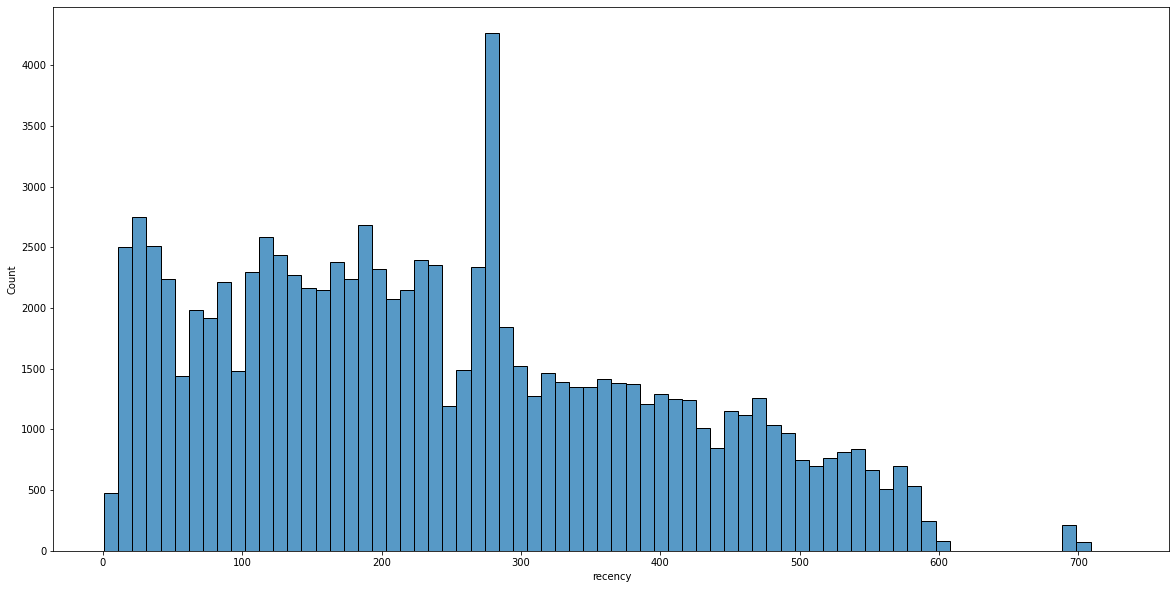

In [103]:
# Plotting to visualize the distribution of recency.
plt.figure(figsize=(20,10))
sns.histplot(rfm.recency) 

Number of days since the last purchase (recency):

- Rank 3: 0 to 300 days
- Rank 2: 300 to 500 days
- Rank 1: 500 to max

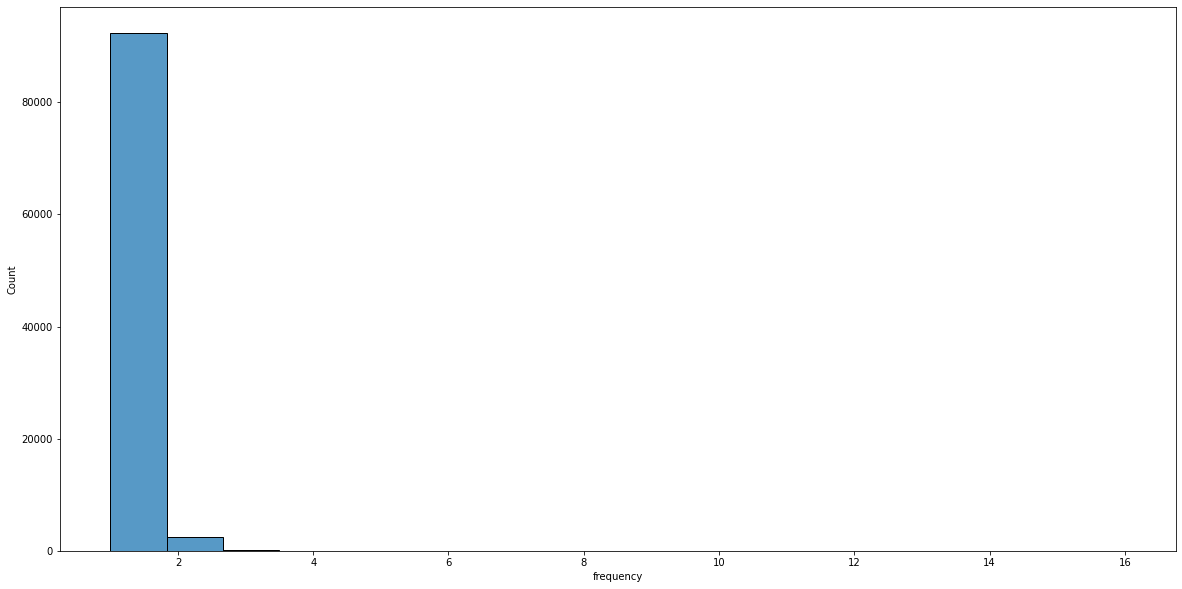

In [104]:
# Plotting to visualize the distribution of frequency
plt.figure(figsize=(20,10))
sns.histplot(rfm.frequency) 

In [105]:
rfm.groupby('frequency').agg({'customer_unique_id': 'count'})

,customer_unique_id
frequency,
1,92340
2,2428
3,162
4,29
5,8
6,4
7,3
9,1
16,1


Number of purchases in the last period (frequency)

I see that most users made only one purchase.

I'll define custom ranges:

- Rank 1: 1 purchase
- Rank 2: 2 or more purchases
- Rank 3: 3 or more purchases
    

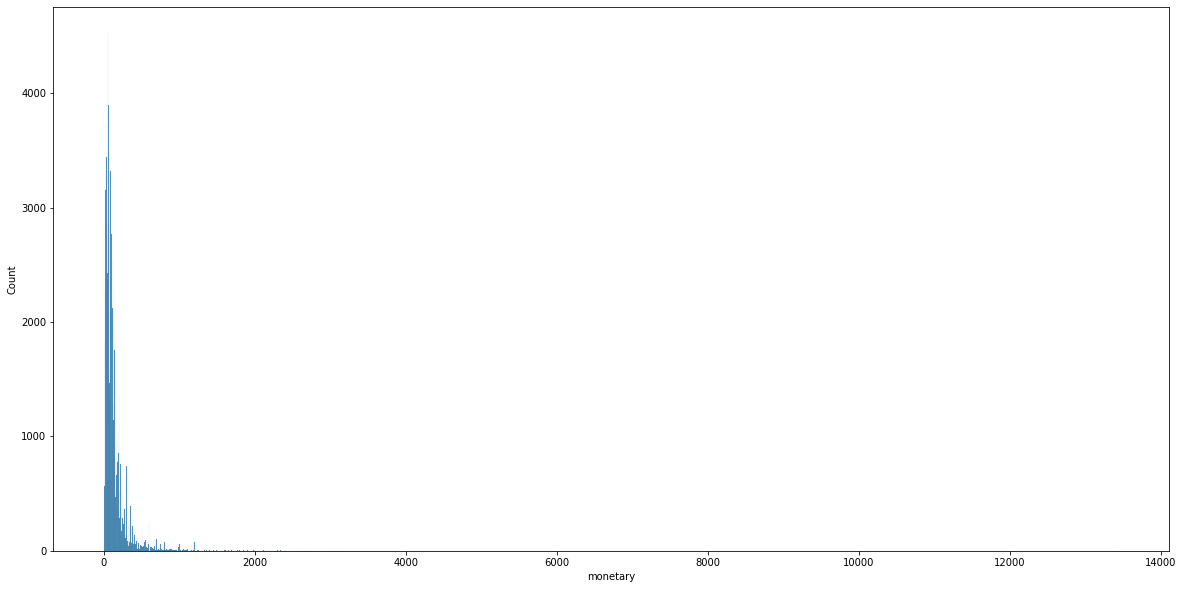

In [106]:
# Plotting to visualize the distribution ofmonetary
plt.figure(figsize=(20,10))
sns.histplot(rfm.monetary) 

In [107]:
rfm.groupby('monetary', as_index = False)\
    .agg({'customer_unique_id':'count'})\
    .sort_values('customer_unique_id', ascending =False)

,monetary,customer_unique_id
1716,59.90,1603
1982,69.90,1493
1372,49.90,1335
2503,89.90,1153
2791,99.90,1128
...,...,...
2082,73.88,1
2084,73.97,1
5266,229.60,1
5265,229.60,1


Order amount (monetary)

I see there are some significant outliers, so I'll define custom ranges:

- Rank 1: 0 to 1000
- Rank 2: 1001 to 4000
- Rank 3: 4001 to maximum

In [108]:
def r_score(x):
    if x <= 300:
        return 3
    elif 300 < x <= 500:
        return 2
    else:
        return 1



In [109]:

def f_score(x):
    if x == 1 :
        return 1
    elif x==2 :
        return 2
    elif x >= 3:
        return 3
   
   

In [110]:

def m_score(x):
    if x < 1000 :
        return 1
    elif x >= 1000 and x <= 4000 :
        return 2
    elif x > 4001 :
        return 3


In [111]:
# Calling the function and saving the results in columns R/F/M
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

In [112]:
rfm.isna().sum()

customer_unique_id    0
recency               0
frequency             0
monetary              0
R                     0
F                     0
M                     0
dtype: int64

In [113]:
# Combining the R, F, and M scores into one RFM Score.
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)

#### Description of segments

##### Top Customers:
Customers who purchase frequently, spend a lot of money, and made their last purchase recently.
- R: 3
- F: 3
- M: 3

   
##### Regular Customers:
Customers who purchase frequently, spend average amounts of money, and made their last purchase recently.
- R: 3, 2, 2
- F: 3, 3, 2
- M: 2, 2, 2


##### Potential Regular Customers:
Customers who made purchases recently, spend average amounts of money, and have the potential to purchase more frequently.
- R: 3, 3, 3, 1, 2
- F: 2, 1, 1, 2, 1
- M: 2, 3, 2, 3, 3


##### Loyal, Low Spenders:
Customers who purchase frequently but spend little money and made their last purchase recently.
- R: 3, 3, 2, 2
- F: 3, 2, 3, 2
- M: 1, 1, 1, 1


 
##### New Customers:
Customers who made purchases recently, made only one purchase, and spend little money.
- R: 3
- F: 1
- M: 1


##### Potential High Spenders:
Customers who purchase frequently, spend a lot of money, and have the potential to purchase more frequently.
- R: 2
- F: 3
- M: 3

    
##### Struggling Customers:
Customers who haven't made purchases recently, made only one purchase, and spend little money.
- R: 2, 2
- F: 1, 1
- M: 1, 2

    
##### Lost Customers:
Customers who haven't made purchases for a long time, made only one purchase, varying amounts of money spent.
- R: 1, 1, 1, 1, 1
- F: 1, 2, 1, 1, 3
- M: 1, 1, 2, 3, 1

In [114]:
# segment pattern
segt_map = {
    r'333': 'Top Customers',
    r'332|232|222': 'Regular Customers',
    r'322|313|312|123|213': 'Potential Regular Customers',
    r'331|321|231|221': 'Loyal, Low Spenders',
    r'311': 'New Customers',
    r'233': 'Potential High Spenders',
    r'211|212': 'Struggling Customers',
    r'111|121|112|113|131': 'Lost Customers'
    
}


rfm['segment'] = rfm['RFM_Score']
# Replace value by key
rfm['segment'] = rfm['segment'].replace(segt_map, regex=True)


In [115]:
rfm.head()

,customer_unique_id,recency,frequency,monetary,R,F,M,RFM_Score,segment
0,0000366f3b9a7992bf8c76cfdf3221e2,116,1,129.90,3,1,1,311,New Customers
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,18.90,3,1,1,311,New Customers
2,0000f46a3911fa3c0805444483337064,542,1,69.00,1,1,1,111,Lost Customers
3,0000f6ccb0745a6a4b88665a16c9f078,326,1,25.99,2,1,1,211,Struggling Customers
4,0004aac84e0df4da2b147fca70cf8255,293,1,180.00,3,1,1,311,New Customers


In [116]:
# Calculation of the number of users in segments
data = rfm.groupby('segment',as_index = False)\
    .agg({'customer_unique_id':'count'})\
    .sort_values('customer_unique_id', ascending = False)\
    .rename(columns = {'customer_unique_id':'number_of_users'})
data

,segment,number_of_users
2,New Customers,61694
5,Struggling Customers,23657
0,Lost Customers,6529
1,"Loyal, Low Spenders",2465
3,Potential Regular Customers,606
4,Regular Customers,24
6,Top Customers,1


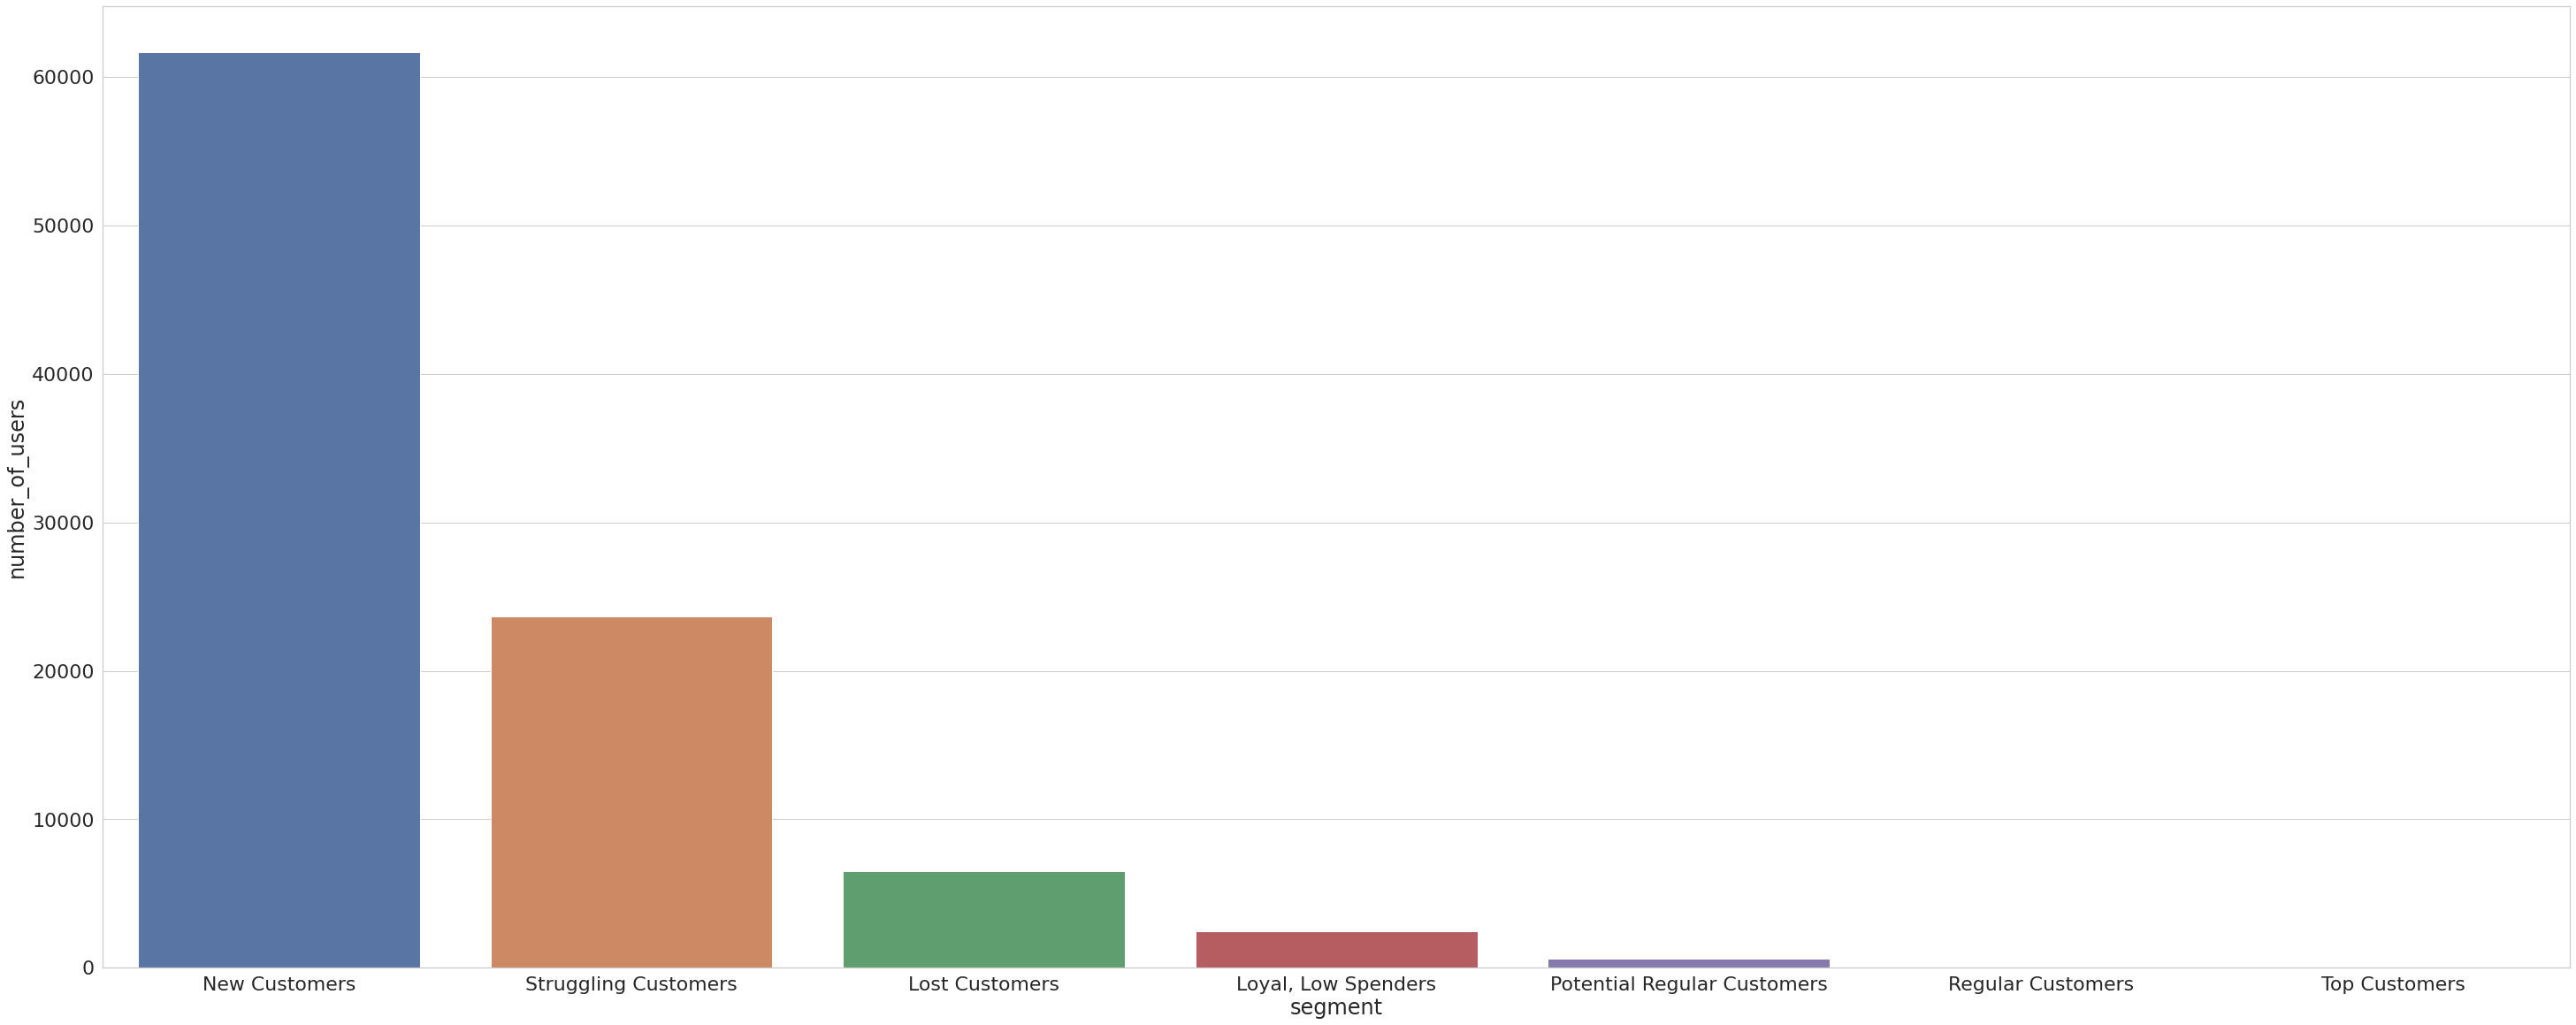

In [117]:
sns.set(
    font_scale =2,
    style = 'whitegrid',
    rc = {'figure.figsize' : (50,20)}
)
sns.barplot(data= data, x= 'segment', y = 'number_of_users')

The highest number of new customers is observed.

There is also a significantly large number of users classified as Struggling Customers
(users who have not made purchases for a long time, have made only one purchase, and spend little money).